In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
view_classes = Base.classes.keys()
view_classes

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement   # Class I
Station = Base.classes.station           # Class II

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
last_12mo_precipitation = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-24').filter(Measurement.date <= '2017-08-23').group_by(Measurement.date).all()
# last_12mo_precipitation

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_12mo_precipitation, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date',inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values(by=['Date'])

precipitation_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.00
2017-08-20,0.00
2017-08-21,0.00


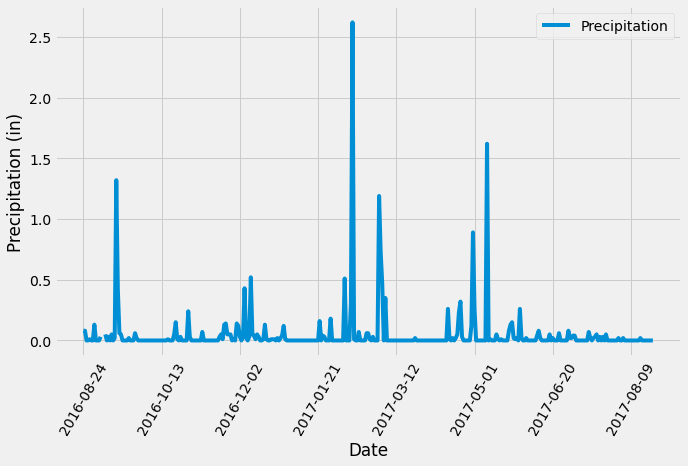

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x_compat=True, figsize=(10,6))
plt.ylabel("Precipitation (in)")
plt.xlabel("Date")
plt.xticks(rotation='60')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_results[0][0]
station_stats = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
session.query(*station_stats).\
                filter(Measurement.station == most_active).all()

[(54.0, 71.66378066378067, 85.0)]

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most recent date
most_recent_date = session.query(Measurement.date).\
                            filter(Measurement.station == most_active).\
                            order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-18')

In [47]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12mo_temp = session.query(Measurement).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= '2016-08-19').statement

df_12mo_t = pd.read_sql_query(last_12mo_temp, session.bind)
df_12mo_t.head()

,id,station,date,prcp,tobs
0,14604,USC00519281,2016-08-19,0.31,79.0
1,14605,USC00519281,2016-08-20,0.13,81.0
2,14606,USC00519281,2016-08-21,0.08,79.0
3,14607,USC00519281,2016-08-22,2.32,78.0
4,14608,USC00519281,2016-08-23,1.79,77.0


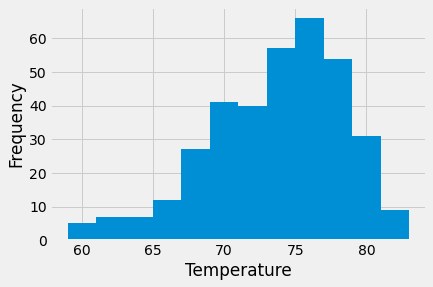

In [56]:
# Plot results as an histogram
plt.hist(df_12mo_t["tobs"], bins = 12)
# plt.figure(figsize=(12, 8))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [57]:
# Close Session
session.close()